In [1]:
import featuretools as ft
import pandas as pd
import numpy as np
import seaborn as sns
import simfin as sf
import math
import datetime as date
from datetime import timedelta  
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings("ignore")

## Mean Reversion on Equities: Implementation of Statistical Arbitrage Fundamental and estimation on alpha using the Ornstein-Ulhenbeck Process

In [2]:
#collect data from api
sf.set_api_key('PLEbHyzQgm98TrvHFejzBwikq1mKiJob ')
sf.set_data_dir('~/simfin_data/')
sf.set_data_dir('C:/Users/suher/Python/Springboard/Capstone 2')
figures_and_ratios = sf.load_derived(variant = 'quarterly',market = 'us')
sector_industry = sf.load_industries()
balance_sheet = sf.load_balance(variant='quarterly-full', market='us')
companies = sf.load_companies(market='us')
cash_flow = sf.load_cashflow(variant='quarterly-full', market='us')
income_statement = sf.load_income(variant='quarterly-full', market='us')
historical_prices = sf.load_shareprices(variant = 'daily', market = 'us')
price_ratios = sf.load_derived_shareprices(variant='daily', market='us')


sp500_daily = pd.read_csv('sp500daily.csv')
sp500_list = list(pd.read_csv('constituents_csv.csv')['Symbol'])
sp500_daily.Date =  pd.to_datetime(sp500_daily.Date)

hp = historical_prices.reset_index()
hp = hp[hp['Ticker'].isin(sp500_list)]
companies = companies.reset_index()
companies = companies[companies['Ticker'].isin(sp500_list)]

sector_industry.Sector.unique()

sp500_daily.set_index('Date',inplace=True)

sector_industry.reset_index(inplace=True)
comp_sector = pd.merge(companies,sector_industry,how='left',left_on='IndustryId',right_on='IndustryId')

hp_ = pd.merge(hp,comp_sector[['SimFinId','Sector']],how='left',left_on='SimFinId',right_on='SimFinId')

t_hp = hp_[hp_['Sector'] == 'Technology']
f_hp = hp_[hp_['Sector'] == 'Financial Services']
s_hp = sp500_daily[['Open','Close']]

s_open = s_hp.Open
s_close = s_hp.Close
t_open = t_hp.set_index('Date').pivot(columns='Ticker',values='Open')
t_close = t_hp.set_index('Date').pivot(columns='Ticker',values='Close')
f_open = f_hp.set_index('Date').pivot(columns='Ticker',values='Open')
f_close = f_hp.set_index('Date').pivot(columns='Ticker',values='Close')

st_close = pd.DataFrame(s_close).join(t_close)
st_close.rename(columns={'Close':'SPX'},inplace=True)
st_close_ret = st_close.pct_change().iloc[1:,:]

Dataset "us-derived-quarterly" on disk (16 days old).
- Loading from disk ... Done!
Dataset "industries" on disk (16 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly-full" on disk (15 days old).
- Loading from disk ... Done!
Dataset "us-companies" on disk (16 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly-full" on disk (15 days old).
- Loading from disk ... Done!
Dataset "us-income-quarterly-full" on disk (15 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-derived-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!


In [3]:
historical_prices.loc['AAPL']

,SimFinId,Open,Low,High,Close,Adj. Close,Dividend,Volume,Shares Outstanding
Date,,,,,,,,,
2007-01-03,111052,3.08,2.92,3.09,2.99,2.58,NaN,44225700,NaN
2007-01-04,111052,3.00,2.99,3.07,3.06,2.64,NaN,30259300,NaN
2007-01-05,111052,3.06,3.01,3.08,3.04,2.62,NaN,29812200,NaN
2007-01-08,111052,3.07,3.05,3.09,3.05,2.63,NaN,28468100,NaN
2007-01-09,111052,3.09,3.04,3.32,3.31,2.85,NaN,119617800,NaN
...,...,...,...,...,...,...,...,...,...
2020-11-03,111052,109.66,108.73,111.49,110.44,110.25,NaN,107624448,1.700180e+10
2020-11-04,111052,114.14,112.35,115.59,114.95,114.75,NaN,138235482,1.700180e+10
2020-11-05,111052,117.95,116.87,119.62,119.03,118.82,NaN,126387074,1.700180e+10



Check daily returns data integrity by testing stationarity (anderson-fuller test).

In [4]:
st_close_ret

,SPX,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANET,ANSS,...,SWKS,TEL,TTWO,TWTR,TXN,TYL,VRSN,WDC,XLNX,XRX
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.003116,0.002618,0.016446,-0.001579,-0.015193,0.029707,-0.007692,0.001031,NaN,-0.022401,...,0.015520,-0.014782,0.006731,NaN,-0.005767,0.023645,0.010509,0.026513,-0.012608,0.001159
2010-01-06,0.000546,-0.016971,-0.002122,-0.001898,0.002373,-0.008243,-0.002114,-0.014418,NaN,-0.006645,...,-0.009302,0.020276,-0.002865,NaN,-0.007347,-0.000481,-0.010800,0.000861,-0.006784,-0.009259
2010-01-07,0.004001,-0.001328,-0.019405,-0.007921,0.005525,0.000378,-0.010593,-0.010449,NaN,0.002537,...,-0.011402,-0.018680,-0.004789,NaN,0.003116,-0.013000,-0.013748,-0.019570,-0.010044,0.004673
2010-01-08,0.002882,0.006649,-0.005422,0.005749,0.030612,0.000000,0.038544,-0.004224,NaN,0.006903,...,0.017639,0.012556,0.002887,NaN,0.022913,0.011707,0.007790,0.005045,0.014610,-0.003488
2010-01-11,0.001747,-0.009247,-0.013083,-0.005716,-0.000381,-0.003399,0.021993,-0.030753,NaN,0.003885,...,0.000667,-0.008800,0.024952,NaN,-0.012908,-0.011090,-0.002848,0.001091,-0.010400,0.024504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.000195,0.000986,0.002098,0.004615,0.005412,-0.002095,0.006876,0.023757,-0.001123,0.002972,...,0.017746,0.001262,0.014821,0.002158,-0.000156,0.003295,0.001663,-0.007496,-0.004146,0.000535
2019-12-26,0.005128,0.019840,0.004732,0.000084,0.001794,0.007115,-0.003089,0.001934,0.004740,0.007174,...,0.000982,0.001155,0.000484,0.004000,-0.000389,0.006870,0.004981,0.009160,0.001929,0.002944
2019-12-27,0.000034,-0.000414,-0.001238,-0.002339,0.006188,0.001853,-0.002283,-0.009650,-0.005739,0.001355,...,0.000082,0.002098,0.003871,-0.002452,0.000700,0.000433,0.001755,-0.010669,-0.002635,-0.004536


In [5]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(df): 
    adf_scores = []
    for i in list(df.columns): 
        curr_adf = adfuller(df[i].dropna())
        if curr_adf[1] > .05: 
            print('return of '+ i +'is not stationary')
        adf_scores.append(curr_adf[1])
    print(adf_scores)   
    
check_stationarity(st_close_ret)

[5.553316228250892e-21, 0.0, 0.0, 0.0, 4.9922408583287756e-27, 0.0, 2.038736506225406e-30, 0.0, 0.0, 0.0, 0.0, 4.381051964154431e-29, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.493561648922373e-26, 0.0, 0.0, 0.0, 0.0, 4.38949639290485e-26, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.360825648999867e-30, 0.0, 0.0, 0.0, 8.111678817735038e-28, 1.6110881279268902e-27, 7.96407307737618e-18, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.904098580702446e-19, 0.0, 0.0, 0.0, 0.0, 0.0]


Checking integrity of data returns are stationary, proceeding to EDA on tech daily returns.

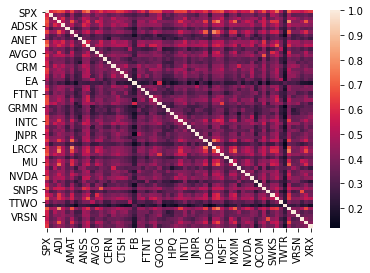

In [6]:
st_cormat = st_close_ret.corr()

sns.heatmap(st_cormat)

In [7]:
st_cormat.head()

,SPX,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANET,ANSS,...,SWKS,TEL,TTWO,TWTR,TXN,TYL,VRSN,WDC,XLNX,XRX
SPX,1.000000,0.594454,0.640472,0.683298,0.653121,0.508136,0.647975,0.447742,0.405457,0.676361,...,0.583891,0.735098,0.498561,0.299533,0.702269,0.572662,0.565424,0.535550,0.589004,0.622795
AAPL,0.594454,1.000000,0.391650,0.451282,0.404948,0.288814,0.449266,0.301571,0.290395,0.420987,...,0.495559,0.443582,0.337278,0.246508,0.466154,0.336545,0.344159,0.342228,0.368228,0.328292
ADBE,0.640472,0.391650,1.000000,0.489951,0.597206,0.377447,0.474976,0.327088,0.381254,0.544977,...,0.385006,0.473604,0.417703,0.286828,0.488523,0.501832,0.426522,0.371542,0.436130,0.388711
ADI,0.683298,0.451282,0.489951,1.000000,0.518988,0.392218,0.668798,0.436903,0.336469,0.510570,...,0.623242,0.619291,0.385259,0.253183,0.790528,0.417567,0.409653,0.487627,0.687649,0.454002
ADSK,0.653121,0.404948,0.597206,0.518988,1.000000,0.403540,0.517180,0.360747,0.386889,0.593243,...,0.467301,0.539521,0.382253,0.293418,0.527280,0.456132,0.451628,0.433908,0.460370,0.418679


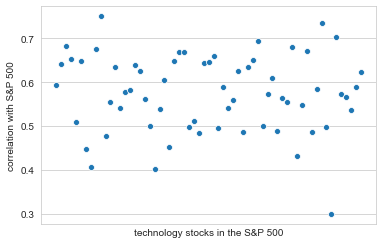

In [8]:
sns.set_style('whitegrid')
spcor = sns.scatterplot(x=st_cormat.columns[1:],y=st_cormat.SPX[1:]);
plt.ylabel('correlation with S&P 500');
plt.xlabel('technology stocks in the S&P 500');
spcor.axes.get_xaxis().set_ticks([]);

Test creating a base capm model.

In [9]:
tech_etf = ['IXN','IGM','IGV','XNTK','XLK','XSD','VGT','RYT','XSW']

etf_daily_close = pd.read_csv('IXN.csv')
etf_daily_close = etf_daily_close[['Date','Close']]
for i in tech_etf[1:]: 
    etf_csv = i +'.csv'
    etf_df = pd.read_csv(etf_csv)[['Date','Close']]
    etf_daily_close = pd.merge(etf_daily_close,etf_df,how='left',left_on='Date',right_on='Date')

pd.read_csv('IXN.csv').head()
etf_daily_close['Date'] = pd.to_datetime(etf_daily_close['Date'])
etf_daily_close.set_index('Date',inplace=True)
etf_daily_close.columns = tech_etf
etf_daily_ret = etf_daily_close.pct_change()[1:]
stETF = st_close_ret.join(etf_daily_ret)
stETF.head()


,SPX,AAPL,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANET,ANSS,...,XRX,IXN,IGM,IGV,XNTK,XLK,XSD,VGT,RYT,XSW
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.003116,0.002618,0.016446,-0.001579,-0.015193,0.029707,-0.007692,0.001031,NaN,-0.022401,...,0.001159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,0.000546,-0.016971,-0.002122,-0.001898,0.002373,-0.008243,-0.002114,-0.014418,NaN,-0.006645,...,-0.009259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,0.004001,-0.001328,-0.019405,-0.007921,0.005525,0.000378,-0.010593,-0.010449,NaN,0.002537,...,0.004673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,0.002882,0.006649,-0.005422,0.005749,0.030612,0.000000,0.038544,-0.004224,NaN,0.006903,...,-0.003488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,0.001747,-0.009247,-0.013083,-0.005716,-0.000381,-0.003399,0.021993,-0.030753,NaN,0.003885,...,0.024504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


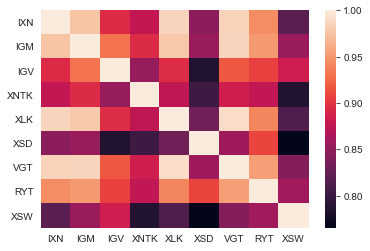

In [10]:
sns.heatmap(etf_daily_ret.corr())

trying in normal CAPM model on MSFT

In [11]:

import statsmodels.api as sm

stETF = st_close_ret.join(etf_daily_ret)

spx = stETF['SPX']
msft = stETF['MSFT']
x = sm.add_constant(spx)
lr = sm.OLS(msft,x)
results = lr.fit()
msft_spx = results.predict(x)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MSFT   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     2328.
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:24:11   Log-Likelihood:                 7932.8
No. Observations:                2515   AIC:                        -1.586e+04
Df Residuals:                    2513   BIC:                        -1.585e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.254      0.210      -0.000       0.001
SPX            1.0688      0.022     48.253      0.000       1.025       1.112
==============================================================================
Omnibus:                      598.950   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29908.667
Skew:                           0.187   Prob(JB):                         0.00
Kurtosis:                      19.890   Cond. No.                         108.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
np.cumprod(stETF['SPX']+1)

Date
2010-01-05    1.003116
2010-01-06    1.003663
2010-01-07    1.007679
2010-01-08    1.010583
2010-01-11    1.012348
                ...   
2019-12-24    2.845021
2019-12-26    2.859610
2019-12-27    2.859708
2019-12-30    2.843176
2019-12-31    2.851552
Name: SPX, Length: 2515, dtype: float64

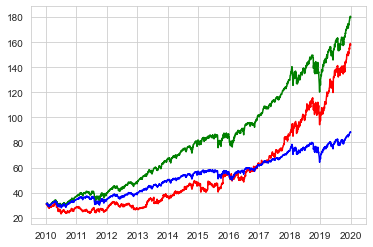

In [13]:
pred_msft = st_close.iloc[0]['MSFT'] * np.cumprod(msft_spx+1)
spx_ret = st_close.iloc[0]['MSFT'] * np.cumprod(stETF['SPX']+1)
plt.plot(st_close['MSFT'],'r')
plt.plot(pred_msft,'g')
plt.plot(spx_ret,'b')

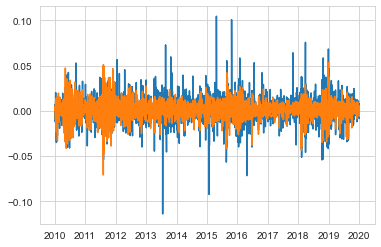

In [14]:
plt.plot(msft)
plt.plot(msft_spx)

In [15]:
x = stETF.loc[:,tech_etf].dropna()
y = stETF.loc[x.index[0]:x.index[-1],:]['MSFT']
#y = st_close_ret.loc[x.index[0],:]['GOOG'].dropna()
#x = st_close_ret.loc[y.index[0],:]['SPX']
x = sm.add_constant(x)
lr = sm.OLS(y,x)
results = lr.fit()
msft_etf = results.predict(x)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MSFT   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     381.6
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:24:11   Log-Likelihood:                 6689.9
No. Observations:                2011   AIC:                        -1.336e+04
Df Residuals:                    2001   BIC:                        -1.330e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.217      0.224      -0.000       0.001
IXN           -0.0102      0.102     -0.100      0.921      -0.211       0.191
IGM            0.7274      0.120      6.074      0.000       0.493       0.962
IGV            0.4399      0.050      8.743      0.000       0.341       0.539
XNTK          -0.0087      0.031     -0.279      0.780      -0.070       0.052
XLK            0.9794      0.142      6.900      0.000       0.701       1.258
XSD           -0.1279      0.031     -4.117      0.000      -0.189      -0.067
VGT           -0.3365      0.169     -1.989      0.047      -0.668      -0.005
RYT           -0.3925      0.080     -4.916      0.000      -0.549      -0.236
XSW           -0.2158      0.036     -6.025      0.000      -0.286      -0.146
==============================================================================
Omnibus:                      516.236   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22003.487
Skew:                           0.418   Prob(JB):                         0.00
Kurtosis:                      19.183   Cond. No.                     1.04e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

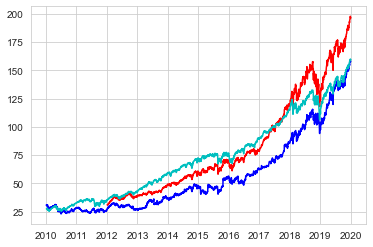

In [17]:
pred_msft_etf = st_close.iloc[0]['MSFT'] * np.cumprod(msft_etf+1)
pred_msft_ind = st_close.loc[pred_msft_etf.index[0]:]['MSFT'].iloc[0] * np.cumprod(msft_spx+1)
plt.plot(pred_msft_etf, 'r')
plt.plot(st_close['MSFT'], 'b')
plt.plot(pred_msft_ind, 'c')

In [18]:
def regress_pca(stock,pca_factors): 
    pca_f = PCA(n_components = 1)
    pca_f.fit(pca_factors)
    features = pca_f.transform(pca_factors)
    features = pd.DataFrame(features,index=pca_factors.index,columns=['etf_pca1'])
    x_pca = sm.add_constant(features)
    y = stock
    lr = sm.OLS(y,x_pca)
    results = lr.fit()
    alpha = results.params[0]
    beta1 = results.params[1]
    res = y - beta1 * x_pca.iloc[:,1] -alpha
    #beta2 = results.params[2]
    return alpha,beta1,res

def calc_ar1(residual): 
    ar1 = ARIMA(residual,order=(1,0,0)).fit()
    ar1_a = ar1.params[0]
    ar1_b = ar1.params[1]
    ar1_res  = ar1.resid
    return ar1_a,ar1_b,ar1_res

def compute_s_score(a,b,r):
    m = r.mean()
    if b > 0: 
        std_r_eq = r.std()/np.sqrt(2 * b)
    else: 
        std_r_eq =  r.std()/-np.sqrt(2 * abs(b))
    s = (r[-1]- m)/std_r_eq
    return s,std_r_eq,m

def calculate_signals(s,b,window): 
    signal = pd.DataFrame(columns = s.columns, index = s.index[window:])
    for i in range(0,s.shape[1]): 
        print('running for'+ " " + s.columns[i])
        curr_s = s.iloc[:,i]
        for j in range(window,s.shape[0]-20):
            if(j%200 == 0): 
                print("currently at iteration: "+ str(j))
            stock = s.iloc[j:j+window,i]
            pca_f = b.iloc[j:j+window,:]
            alpha,beta,res = regress_pca(stock,pca_f)
            ar1_a,ar1_b,ar1_res = calc_ar1(res.mean() - res)
            signal.loc[stock.index[-1],s.columns[i]] = compute_s_score(ar1_a,ar1_b,res)[0]
    return signal
        
    

In [19]:
#test_run
stetf = stETF[stETF['IXN'].notna()]
s = stetf['AAPL']
b = stetf.loc[:,tech_etf]
alpha,beta,residual  = regress_pca(s,b)
a,b,r = calc_ar1(residual)
compute_s_score(a,b,r)

(0.10045311393432624, 0.03896500981860404, -1.970230003946434e-07)

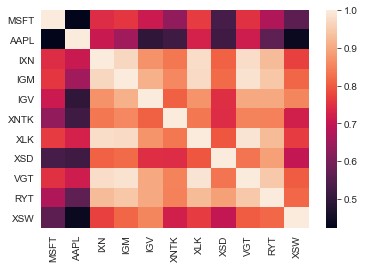

In [20]:
check_cor = stetf[['MSFT','AAPL']]
check_cor = check_cor.join(stetf.loc[:,tech_etf])
corr = check_cor.corr()[['MSFT','AAPL']]
sns.heatmap(check_cor.corr())

In [ ]:
s = stetf[['AAPL']]
b = stetf.loc[:,tech_etf]
windows = 60
s_score = calculate_signals(s,b,windows)
s_score = s_score.dropna()
s_score.rename({'AAPL':'s_score'},axis=1,inplace=True)
s_score = s_score.join(stetf['AAPL']+1)

In [ ]:
s = s_train.dropna(axis=1)
b = s_train.loc[:,tech_etf]
windows = 60
s_score_all = calculate_signals(s,b,windows)
s_score_all.to_csv('s_score_all_tech_train.csv')

In [ ]:
s_score_all = s_score_all[60:]
s_score_all

In [21]:
s_tech = pd.read_csv('s_score_all_tech_b.csv').dropna().dropna(axis=1).set_index('Date')
s_tech_train = pd.read_csv('s_score_all_tech_train.csv').dropna().dropna(axis=1).set_index('Date')
train_range = pd.date_range(start = s_tech.index[0], end = "2016-12-31")
s_tech.index = pd.to_datetime(s_tech.index)

s_tech_train = s_tech[s_tech.index.isin(train_range)]
s_tech_test = s_tech.loc[train_range[-1]:]
train_range = pd.date_range(start = s_tech.index[0], end = "2017-12-31")
s_train = stetf[stetf.index.isin(train_range)]
s_test = stetf.loc[s_train.index[-1]:,:]

In [22]:
s_score = pd.DataFrame(s_tech.AAPL).rename({'AAPL':'AAPL_s'},axis=1)
s_score = s_score.join(stetf['AAPL']+1)
s_score_train = pd.DataFrame(s_tech_train.AAPL).rename({'AAPL':'AAPL_s'},axis=1)
s_score_train = s_score_train.join(stetf['AAPL'])

In [23]:
def sim_long_arb(d_cut = -1,u_cut = 1,ret=False): 
    hold = False;
    cap = 1;
    returns = [];
    transaction_date = []
    for i in s_score_train.iterrows():
        date = i[0]
        current_s = i[1][0]
        current_r = i[1][1]
        if(hold == True): 
            returns.append(current_r)
            if(current_s >= u_cut): 
                hold = False
        elif(hold == False and current_s <= d_cut):
            hold = True
    #print(np.mean(returns))
    #print(np.std(returns))
    returns = np.array(returns)
    std = np.std(returns)
    if std == 0: 
        std=1
    sharpe = np.mean(returns)/ std
    if ret == True: 
        return sharpe,returns
    else: 
        return sharpe

def sim_short_arb(d_cut = -1,u_cut = 1,ret=False): 
    short = False;
    cap = 1;
    returns = [];
    transaction_date = []
    for i in s_score_train.iterrows():
        date = i[0]
        current_s = i[1][0]
        current_r = i[1][1] * -1
        if(short == True): 
            returns.append(current_r)
            if(current_s <= d_cut): 
                short = False
        elif(short == False and current_s >= u_cut):
            short = True
    returns = np.array(returns)
    sharpe = np.mean(returns)/np.std(returns)
    if ret==True: 
        return sharpe,returns
    else:
        return sharpe

In [24]:

smin = s_score.iloc[:,0].min()
smax = s_score.iloc[:,0].max()
opt_long = BayesianOptimization(sim_long_arb,{'d_cut':(-3,-1),'u_cut':(1,3)})
opt_short = BayesianOptimization(sim_short_arb,{'d_cut':(-3,-1),'u_cut':(1,3)})
opt_long.maximize(n_iter = 10)
#opt_short.maximize(n_iter=10)

|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.02434  | -1.902    |  2.425    |
|  2        |  0.01711  | -2.431    |  2.691    |
|  3        |  0.007739 | -1.125    |  1.599    |
|  4        |  0.08574  | -2.938    |  2.139    |
|  5        | -0.3854   | -2.804    |  1.044    |
|  6        |  0.08574  | -2.964    |  2.111    |
|  7        |  0.00394  | -1.0      |  3.0      |
|  8        |  0.08574  | -3.0      |  3.0      |
|  9        | -0.0607   | -1.0      |  1.0      |
|  10       |  0.00394  | -1.0      |  2.28     |
|  11       |  0.02434  | -1.737    |  3.0      |
|  12       |  0.08574  | -2.998    |  2.536    |
|  13       |  0.003517 | -1.721    |  1.826    |
|  14       |  0.08574  | -3.0      |  2.286    |
|  15       |  0.01711  | -2.393    |  2.076    |


In [25]:
print(opt_long.max['params'],opt_long.max['target'])
#print(opt_short.max['params'],opt_short.max['target'])

{'d_cut': -2.9378842445764253, 'u_cut': 2.1394209624489076} 0.08573757065055318


#### parameters are received after optimization for maximum sharpe/sortino ratio over entire dataset, this is to visualize what the "best - case" scenario looks like for a stock


In [27]:
    
def sim_arbitrage(s_score,buy_s,cut_s,cap=1): 
    daily_cap = []
    long = False
    for i in s_score.iterrows(): 
        curr_d = i[0]
        curr_s = i[1][0]
        curr_r = i[1][1]
        daily_cap.append(cap)
        if long == True: 
            cap = cap * curr_r
            if curr_s > cut_s: 
                long = False

        #elif short == True: 
        #    cap = cap * (((curr_r - 1) * -1) + 1)
        #    if curr_s <= -.5: 
        #        short = False

        if curr_s <= buy_s: 
            long = True
        #elif curr_s > 1.25: 
        #    short = True
        
    daily_cap = pd.DataFrame(daily_cap,index = s_score.index,columns= ['value'])
    daily_ret = daily_cap.pct_change()[1:]
    sharpe = daily_ret.mean()/daily_ret.std()
    sortino = daily_ret.mean()/daily_ret[daily_ret<0].std()
    #if(out == 'sh'): 
    return daily_cap,daily_ret,sharpe,sortino
    #if(out == 'so'): 
       # return sortino


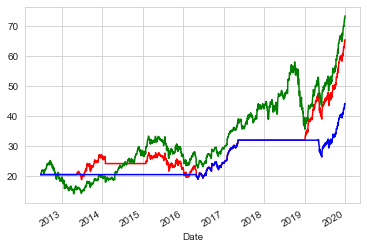

In [28]:

a_sh = [-3.2,1.9]
a_so = [-1.8,2.8]
dc,dr,ds,dso = sim_arbitrage(s_score,a_so[0],a_so[1],20.38)
dcsh,drsh,dssh,dsh = sim_arbitrage(s_score,a_sh[0],a_sh[1],20.38)
dcsh.rename({'value':'sharpe'},axis=1,inplace=True)
test_so_aapl= dc.join(st_close.AAPL)
test_so_aapl=test_so_aapl.join(dcsh)
test_so_aapl.value.plot(color='r')
test_so_aapl.AAPL.plot(color = 'g')
test_so_aapl.sharpe.plot(color='b')

In [29]:
from itertools import product
import random
stock_list = s_tech.columns
def opt_bayesian(s): 
    smin = s.iloc[:,0].min()
    smax = s.iloc[:,0].max()
    print(smin,smax)
    opt_long = BayesianOptimization(sim_long_arb,{'d_cut':(smin,0),'u_cut':(0,smax)})
    try: 
        opt_long.maximize(n_iter=10)
        return opt_long.max['params'],opt_long.max['target']
    except: 
        return -100,-100
    

params = {}
target = {}
for i in stock_list: 
    s_score_train = pd.DataFrame(s_tech_train[i]).rename({i:i+"_s"},axis=1)
    s_score_train = s_score_train.join(stetf[i])
    params[i],target[i] = opt_bayesian(s_score_train)
        
    

-3.2744244243241636 2.7812320547802853
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.02328  | -2.626    |  2.149    |
|  2        |  0.05337  | -0.2536   |  0.9297   |
|  3        |  0.06121  | -0.7574   |  2.261    |
|  4        |  0.0313   | -3.122    |  2.28     |
|  5        | -1.059    | -1.91     |  0.2592   |
|  6        |  0.05031  | -1.755    |  2.781    |
|  7        |  0.06184  | -0.02619  |  2.767    |
|  8        |  0.05912  |  0.0      |  1.739    |
|  9        |  0.03912  |  0.0      |  0.0      |
|  10       |  0.0313   | -2.763    |  2.781    |
|  11       |  0.06026  | -0.8508   |  2.781    |
|  12       |  0.05572  |  0.0      |  0.6915   |
|  13       |  0.08628  | -1.55     |  2.087    |
|  14       |  0.05624  | -0.7982   |  1.588    |
|  15       |  0.0313   | -3.274    |  2.781    |
-3.2331036593329148 3.5296991821561763
|   iter    |  target   |   d_cut   |   u_cut   |
----------------------

|  12       |  3.702    | -5.852    |  0.0      |
|  13       |  0.08107  | -5.852    |  4.003    |
|  14       |  0.04307  |  0.0      |  4.003    |
|  15       |  3.91     | -4.787    |  0.0      |
-2.534958292101555 4.0041167576696495
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.05117  | -0.458    |  1.74     |
|  2        |  0.06474  | -0.752    |  2.925    |
|  3        |  0.1722   | -0.6222   |  0.2659   |
|  4        |  0.1349   | -1.468    |  1.063    |
|  5        |  0.06382  | -0.3115   |  2.964    |
|  6        |  1.435    | -1.559    |  0.0      |
|  7        |  2.144    | -1.907    |  0.0      |
|  8        |  0.01143  | -2.535    |  0.0      |
|  9        |  2.355    | -1.857    |  0.2479   |
|  10       |  2.355    | -1.866    |  0.2283   |
|  11       |  0.2084   | -2.535    |  4.004    |
|  12       |  0.3177   | -2.162    |  0.6756   |
|  13       |  0.2084   | -2.535    |  2.45     |
|  14       

|  9        |  0.1667   | -3.552    |  3.521    |
|  10       |  0.09013  | -2.389    |  3.521    |
|  11       |  0.07678  |  0.0      |  3.521    |
|  12       |  0.8004   | -3.552    |  0.0      |
|  13       |  0.3768   | -3.129    |  0.0      |
|  14       |  0.8004   | -3.552    |  0.2894   |
|  15       |  0.2221   | -3.552    |  0.7239   |
-3.195442766745385 4.898757290251715
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.1104   | -2.085    |  1.651    |
|  2        |  0.05592  | -1.737    |  4.885    |
|  3        |  0.1766   | -2.153    |  1.253    |
|  4        |  0.07471  | -1.925    |  1.923    |
|  5        | -0.1607   | -3.063    |  1.362    |
|  6        |  0.1766   | -2.158    |  1.28     |
|  7        |  0.08721  | -1.318    |  1.085    |
|  8        | -0.2397   | -1.863    |  0.0      |
|  9        |  0.06457  | -0.4532   |  2.143    |
|  10       |  0.05397  | -0.9993   |  3.503    |
|  11       |

|  6        |  0.0461   | -5.818    |  1.051    |
|  7        |  0.008277 | -3.813    |  2.011    |
|  8        |  0.01258  | -4.567    |  0.2074   |
|  9        |  0.0461   | -5.249    |  1.709    |
|  10       |  0.04256  | -6.008    |  2.373    |
|  11       |  0.01169  | -2.034    |  3.142    |
|  12       |  0.01415  |  0.0      |  3.142    |
|  13       |  0.005617 | -5.944    |  0.02583  |
|  14       |  9.43     | -3.397    |  0.0      |
|  15       |  0.7529   | -3.167    |  0.0      |
-7.505498943858865 2.5010995262127134
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.08243  | -6.605    |  1.811    |
|  2        |  0.08243  | -4.267    |  1.514    |
|  3        |  0.09847  | -2.241    |  1.779    |
|  4        |  0.1075   | -2.452    |  1.118    |
|  5        |  0.01786  | -7.324    |  0.7845   |
|  6        |  0.06554  | -1.439    |  0.7789   |
|  7        |  0.08853  | -3.061    |  1.503    |
|  8        

|  3        | -0.03722  | -3.423    |  2.94     |
|  4        |  0.01501  | -0.5229   |  4.259    |
|  5        |  0.07127  | -2.464    |  2.885    |
|  6        |  0.07127  | -2.445    |  2.852    |
|  7        |  0.03234  | -1.9      |  3.173    |
|  8        |  0.04092  | -2.082    |  2.016    |
|  9        |  0.07208  | -1.984    |  0.8564   |
|  10       |  0.4136   | -1.935    |  0.1564   |
|  11       |  0.0708   | -1.67     |  0.0      |
|  12       |  0.0637   | -0.9498   |  1.162    |
|  13       |  0.5389   | -2.009    |  0.2623   |
|  14       |  0.5522   | -2.219    |  0.2277   |
|  15       |  0.0233   | -0.000255 |  1.348    |
-5.803443781289317 3.7346007862637576
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        | -0.005007 | -0.6063   |  0.7511   |
|  2        |  0.07082  | -3.193    |  2.618    |
|  3        |  0.009675 | -0.6069   |  3.347    |
|  4        | -0.06115  | -2.114    |  1.722    |
|  5        

|  3        |  0.06777  | -1.179    |  3.123    |
|  4        |  0.05735  | -0.7274   |  1.418    |
|  5        |  0.05325  | -0.1597   |  2.03     |
|  6        | -0.03481  | -2.662    |  1.593    |
|  7        |  0.03446  |  0.0      |  0.4758   |
|  8        |  0.05514  | -0.2036   |  3.626    |
|  9        |  0.05599  | -1.537    |  4.259    |
|  10       |  0.0575   | -0.459    |  5.416    |
|  11       |  0.05621  | -1.77     |  5.884    |
|  12       |  0.06404  | -2.819    |  4.978    |
|  13       |  0.06404  | -2.808    |  3.88     |
|  14       |  0.05621  | -2.819    |  5.923    |
|  15       |  0.04029  | -2.038    |  3.365    |
-4.653188511045852 4.827877409983981
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.03159  | -2.382    |  4.82     |
|  2        |  0.03188  | -4.609    |  1.477    |
|  3        |  0.03188  | -3.821    |  2.232    |
|  4        | -0.03045  | -3.068    |  2.766    |
|  5        |

|  3        |  0.05296  | -0.1787   |  2.645    |
|  4        |  0.04552  | -4.213    |  2.425    |
|  5        |  0.05928  | -0.7473   |  0.9351   |
|  6        |  0.09145  |  0.0      |  0.0      |
|  7        |  0.2596   | -0.6359   |  0.0      |
|  8        |  0.003076 | -1.289    |  0.7847   |
|  9        |  0.003675 | -2.864    |  0.7598   |
|  10       | -0.02623  | -3.671    |  1.045    |
|  11       |  0.1434   | -0.8981   |  0.007731 |
|  12       |  0.04223  | -1.219    |  2.417    |
|  13       |  0.04998  | -2.038    |  2.433    |
|  14       |  0.09737  | -0.5416   |  0.1629   |
|  15       |  0.2499   | -0.7193   |  0.01695  |
-5.43071088061304 4.712716910242781
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        | -0.3317   | -3.073    |  0.02276  |
|  2        |  0.03064  | -2.926    |  1.176    |
|  3        |  0.07764  | -3.817    |  2.581    |
|  4        |  0.05842  | -2.65     |  3.115    |
|  5        | 

|  1        | -0.01886  | -1.523    |  1.048    |
|  2        |  0.02094  | -0.03121  |  0.6342   |
|  3        | -0.01626  | -2.615    |  4.214    |
|  4        |  0.01653  | -0.8003   |  4.493    |
|  5        | -0.07626  | -1.558    |  0.7945   |
|  6        |  0.02686  | -0.4643   |  1.386    |
|  7        |  0.02253  | -0.4305   |  1.181    |
|  8        |  0.03235  | -0.126    |  1.379    |
|  9        |  0.02693  | -0.1984   |  1.781    |
|  10       | -0.01598  | -0.8457   |  0.949    |
|  11       |  0.07879  | -1.318    |  0.688    |
|  12       |  0.07879  | -1.321    |  0.6735   |
|  13       | -0.01652  | -1.202    |  0.6554   |
|  14       | -0.01801  | -1.058    |  0.07699  |
|  15       | -0.08812  | -1.395    |  0.701    |
-4.8794226238264375 2.4086167420258597
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.0142   | -2.848    |  0.6583   |
|  2        |  0.01128  | -0.7172   |  1.385    |
|  3       

|  15       |  0.1504   | -1.845    |  0.3262   |
-7.161692601933992 3.148232858793987
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.07286  | -2.409    |  2.732    |
|  2        |  0.02939  | -0.7857   |  0.5889   |
|  3        |  0.08352  | -0.7592   |  1.748    |
|  4        |  0.08857  | -6.205    |  2.277    |
|  5        |  0.07552  | -3.737    |  2.377    |
|  6        | -0.03389  | -6.852    |  0.08946  |
|  7        | -0.1352   | -3.333    |  0.6284   |
|  8        |  0.08539  | -1.487    |  2.245    |
|  9        |  0.08341  | -5.006    |  3.148    |
|  10       |  0.07753  |  0.0      |  3.148    |
|  11       |  0.08341  | -7.162    |  3.148    |
|  12       |  0.08366  | -1.213    |  3.148    |
|  13       |  0.07286  | -3.658    |  3.148    |
|  14       |  0.08341  | -6.128    |  3.148    |
|  15       |  0.07751  |  0.0      |  1.938    |
-2.32601689470941 3.7226282569538887
|   iter    |  target   | 

|  11       |  0.02853  | -3.264    |  3.519    |
|  12       |  0.01459  | -2.659    |  4.234    |
|  13       |  0.02853  | -2.428    |  3.074    |
|  14       |  0.05705  | -1.376    |  3.182    |
|  15       |  0.05101  | -1.04     |  2.548    |
-3.4309533919634156 5.609521147827053
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.01311  | -0.7025   |  1.142    |
|  2        |  0.02259  | -2.384    |  5.147    |
|  3        | -0.006094 | -0.5138   |  0.7596   |
|  4        |  0.4379   | -3.175    |  2.824    |
|  5        |  0.02259  | -2.96     |  4.744    |
|  6        |  0.4379   | -3.431    |  1.824    |
|  7        |  0.5581   | -3.431    |  0.0      |
|  8        |  0.05713  | -2.504    |  0.0      |
|  9        |  0.8343   | -3.431    |  0.7552   |
|  10       |  0.1136   | -2.968    |  1.072    |
|  11       |  0.01711  | -0.43     |  5.117    |
|  12       |  0.02322  | -1.293    |  3.923    |
|  13       

|  7        |  0.0554   | -0.7868   |  1.551    |
|  8        |  0.05781  | -0.1188   |  1.713    |
|  9        |  0.2842   | -2.221    |  0.7833   |
|  10       |  0.1091   | -2.498    |  1.23     |
|  11       | -0.8869   | -2.407    |  0.44     |
|  12       |  0.05757  | -0.7264   |  1.292    |
|  13       |  0.05706  | -1.654    |  1.869    |
|  14       |  0.1852   | -2.181    |  0.8431   |
|  15       |  0.02253  | -0.4157   |  0.1621   |
-3.0419978063222115 2.55875284642633
|   iter    |  target   |   d_cut   |   u_cut   |
-------------------------------------------------
|  1        |  0.03455  | -1.1      |  1.205    |
|  2        |  0.024    | -2.054    |  1.485    |
|  3        |  0.06105  | -0.1823   |  0.4639   |
|  4        | -0.6032   | -2.394    |  0.196    |
|  5        |  0.0403   | -0.7666   |  0.8368   |
|  6        |  0.06982  | -1.403    |  2.559    |
|  7        |  0.05374  | -3.042    |  2.559    |
|  8        |  0.06464  |  0.0      |  2.148    |
|  9        |

In [30]:
opt_s = pd.DataFrame(index=s_tech.columns,columns = ['d_cut','u_cut','expected_sharpe'])
for i in s_tech.columns: 
    opt_s.loc[i]['d_cut'] = params[i]['d_cut']
    opt_s.loc[i]['u_cut'] = params[i]['u_cut']
    opt_s.loc[i]['expected_sharpe'] = target[i]
    

In [31]:
opt_s_tech = opt_s.loc[opt_s.expected_sharpe < 1,:]
opt_s_tech.head()

,d_cut,u_cut,expected_sharpe
SPX,-1.54966,2.08705,0.0862766
AAPL,-3.2331,3.5297,0.0857376
ADBE,-0.420165,1.08761,0.0900351
ADI,-0.677806,0.287961,0.0645875
ADSK,-1.12067,0.671093,0.0934761


In [32]:
s_tech =s_tech.loc[:,s_tech.columns.isin(opt_s_tech.index)]
s_test =s_test.loc[:,s_test.columns.isin(opt_s_tech.index)]
s_tech_test =s_tech_test.loc[:,s_tech_test.columns.isin(opt_s_tech.index)]

In [33]:
daily_signal_sh = pd.DataFrame(columns = list(opt_s_tech.index), index = s_tech_test.index)
daily_signal_so = pd.DataFrame(columns = list(opt_s_tech.index), index = s_tech_test.index)
for column in s_tech_test: 
    sh_buy = s_tech_test[s_tech_test[column]<=opt_s_tech.loc[column,'d_cut']]
    #so_buy = s_tech[s_tech[column]<=opt_s_tech[column][1][0]][column]
    sh_sell = s_tech_test[s_tech_test[column]>=opt_s_tech.loc[column,'u_cut']]
    #so_sell = s_tech[s_tech[column]>=opt_s_tech[column][1][1]][column]
    daily_signal_sh.loc[daily_signal_sh.index.isin(sh_buy.index),column] = "BUY"
    daily_signal_sh.loc[daily_signal_sh.index.isin(sh_sell.index),column] = "SELL"
    #daily_signal_so.loc[daily_signal_so.index.isin(so_buy.index),column] = "BUY"
    #daily_signal_so.loc[daily_signal_so.index.isin(so_sell.index),column] = "SELL"
daily_signal_sh.fillna(0,inplace=True)

In [34]:
s

Date
2012-01-04    0.005446
2012-01-05    0.010833
2012-01-06    0.010717
2012-01-09   -0.001988
2012-01-10    0.003984
                ...   
2019-12-24    0.000986
2019-12-26    0.019840
2019-12-27   -0.000414
2019-12-30    0.005935
2019-12-31    0.007272
Name: AAPL, Length: 2011, dtype: float64

In [35]:
daily_signal_sh

,SPX,AAPL,ADBE,ADI,ADSK,AMD,ANSS,APH,ATVI,AVGO,...,WDC,XLNX,XRX,IXN,IGM,IGV,XLK,XSD,VGT,RYT
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,SELL,0,0,SELL,0,BUY,0,0
2017-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,SELL,0,BUY,0,0
2017-01-05,0,0,0,0,0,0,0,0,SELL,0,...,0,0,0,0,0,SELL,0,BUY,0,0
2017-01-06,0,0,SELL,0,0,0,0,0,0,SELL,...,0,0,0,0,0,SELL,0,BUY,0,0
2017-01-09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,BUY,0,SELL,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,SELL,0,0
2019-12-26,0,0,0,0,0,0,0,0,0,SELL,...,0,0,0,0,0,0,0,BUY,0,0
2019-12-27,0,0,0,0,0,0,0,0,SELL,SELL,...,0,0,0,0,0,SELL,0,BUY,0,0


In [37]:
s_ret_test = stetf.loc[stetf.index.isin(daily_signal_sh.index),stetf.columns.isin(daily_signal_sh.columns)]
s_ret_test = s_ret_test+1

In [39]:
position = pd.DataFrame(index = daily_signal_sh.index,columns = daily_signal_sh.columns)
position.loc[:,:] = 0
cap = 10000
day = 0
pos_record = []
pos_list = []
max_hold = 5
optimal = True
day_ret = []
for i in s_ret_test.iterrows():
    print(pos_list)
    date,ret = i[0],i[1]
    signal = daily_signal_sh.loc[date,:]
    buy_list = list(signal[signal=="BUY"].index)
    sell_list = list(signal[signal=="SELL"].index)
    pos_sorted = opt_s_tech.loc[opt_s_tech.index.isin(position),'expected_sharpe'].sort_values(ascending=False)
    buy_sorted = opt_s_tech.loc[opt_s_tech.index.isin(buy_list),'expected_sharpe'].sort_values(ascending=False)
    sell_sorted = opt_s_tech.loc[opt_s_tech.index.isin(sell_list),'expected_sharpe'].sort_values(ascending=False)

    if len(sell_list) > 0 and any(x in sell_list for x in pos_list): 
        for j in pos_list: 
            if j in sell_sorted: 
                #print("selling: " + j)
                pos_list.remove(j)
    while len(buy_list) > 0 and len(pos_list) < max_hold: 
        #print("buying: "+ 
        if(buy_sorted.index[0] not in pos_list): 
            buy_list.pop(buy_list.index(buy_sorted.index[0]))
            pos_list.append(buy_sorted.index[0])
            buy_sorted = buy_sorted.iloc[1:]
        else:
            buy_list.pop(buy_list.index(buy_sorted.index[0]))
            buy_sorted = buy_sorted.iloc[1:]
    w = 1/len(pos_list)
    position.loc[date,position.columns.isin(pos_list)] = w
    curr_w_mat =  position.loc[date,position.columns.isin(pos_list)]
    pos_record.append(curr_w_mat)
    curr_corr_mat = stetf.loc[:date,stetf.columns.isin(opt_s_tech.index)].corr()
    print(curr_w_mat)
    day_ret.append((position.loc[date] * ret).sum())
    #print((position.loc[date]*ret).sum())
    #if len(buy_list) > 0 and len(pos_list) >= max_hold: 
    #   for i in buy_sorted: 
    #       if(pos_sorted.iloc[-1]['expected_sharpe'])


[]
IBM     0.333333
NTAP    0.333333
XSD     0.333333
Name: 2017-01-03 00:00:00, dtype: object
['XSD', 'IBM', 'NTAP']
IBM     0.333333
NTAP    0.333333
XSD     0.333333
Name: 2017-01-04 00:00:00, dtype: object
['XSD', 'IBM', 'NTAP']
MXIM    0.333333
NTAP    0.333333
XSD     0.333333
Name: 2017-01-05 00:00:00, dtype: object
['XSD', 'NTAP', 'MXIM']
IT      0.25
MXIM    0.25
NTAP    0.25
XSD     0.25
Name: 2017-01-06 00:00:00, dtype: object
['XSD', 'NTAP', 'MXIM', 'IT']
IT      0.333333
NTAP    0.333333
IGV     0.333333
Name: 2017-01-09 00:00:00, dtype: object
['NTAP', 'IT', 'IGV']
IT      0.5
NTAP    0.5
Name: 2017-01-10 00:00:00, dtype: object
['NTAP', 'IT']
IBM     0.25
IT      0.25
NTAP    0.25
XSD     0.25
Name: 2017-01-11 00:00:00, dtype: object
['NTAP', 'IT', 'XSD', 'IBM']
IBM     0.25
IT      0.25
NTAP    0.25
XSD     0.25
Name: 2017-01-12 00:00:00, dtype: object
['NTAP', 'IT', 'XSD', 'IBM']
ADBE    0.25
IBM     0.25
IT      0.25
NTAP    0.25
Name: 2017-01-13 00:00:00, dtype: obje

IPGP    0.2
IT      0.2
NTAP    0.2
SWKS    0.2
XSD     0.2
Name: 2017-04-18 00:00:00, dtype: object
['NTAP', 'IT', 'SWKS', 'IPGP', 'XSD']
IPGP    0.2
IT      0.2
LRCX    0.2
NTAP    0.2
SWKS    0.2
Name: 2017-04-19 00:00:00, dtype: object
['NTAP', 'IT', 'SWKS', 'IPGP', 'LRCX']
IPGP    0.2
IT      0.2
LRCX    0.2
NTAP    0.2
SWKS    0.2
Name: 2017-04-20 00:00:00, dtype: object
['NTAP', 'IT', 'SWKS', 'IPGP', 'LRCX']
IPGP    0.2
IT      0.2
LRCX    0.2
NTAP    0.2
SWKS    0.2
Name: 2017-04-21 00:00:00, dtype: object
['NTAP', 'IT', 'SWKS', 'IPGP', 'LRCX']
IPGP    0.2
IT      0.2
LRCX    0.2
NTAP    0.2
SWKS    0.2
Name: 2017-04-24 00:00:00, dtype: object
['NTAP', 'IT', 'SWKS', 'IPGP', 'LRCX']
GLW     0.2
IPGP    0.2
IT      0.2
NTAP    0.2
SWKS    0.2
Name: 2017-04-25 00:00:00, dtype: object
['NTAP', 'IT', 'SWKS', 'IPGP', 'GLW']
GLW     0.2
IPGP    0.2
IT      0.2
NTAP    0.2
SWKS    0.2
Name: 2017-04-26 00:00:00, dtype: object
['NTAP', 'IT', 'SWKS', 'IPGP', 'GLW']
GLW     0.2
IPGP    0.2

APH     0.2
IPGP    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2017-07-28 00:00:00, dtype: object
['NTAP', 'IT', 'IPGP', 'SNPS', 'APH']
APH     0.2
IPGP    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2017-07-31 00:00:00, dtype: object
['NTAP', 'IT', 'IPGP', 'SNPS', 'APH']
APH     0.2
IPGP    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2017-08-01 00:00:00, dtype: object
['NTAP', 'IT', 'IPGP', 'SNPS', 'APH']
APH     0.2
IPGP    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2017-08-02 00:00:00, dtype: object
['NTAP', 'IT', 'IPGP', 'SNPS', 'APH']
APH     0.2
IPGP    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2017-08-03 00:00:00, dtype: object
['NTAP', 'IT', 'IPGP', 'SNPS', 'APH']
APH     0.2
IPGP    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2017-08-04 00:00:00, dtype: object
['NTAP', 'IT', 'IPGP', 'SNPS', 'APH']
APH     0.2
IPGP    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2017-08-07 00:00:00, dtype: object
['NTAP', 'IT', 'IPGP', 'SNPS', 'APH']
APH     0.2
IPGP    0.2
IT 

IBM     0.2
IT      0.2
NTAP    0.2
SNPS    0.2
XRX     0.2
Name: 2017-11-03 00:00:00, dtype: object
['NTAP', 'IT', 'SNPS', 'XRX', 'IBM']
IBM     0.2
IT      0.2
NTAP    0.2
SNPS    0.2
XRX     0.2
Name: 2017-11-06 00:00:00, dtype: object
['NTAP', 'IT', 'SNPS', 'XRX', 'IBM']
IT      0.2
NTAP    0.2
SNPS    0.2
XRX     0.2
XSD     0.2
Name: 2017-11-07 00:00:00, dtype: object
['NTAP', 'IT', 'SNPS', 'XRX', 'XSD']
IT      0.2
NTAP    0.2
SNPS    0.2
TXN     0.2
XSD     0.2
Name: 2017-11-08 00:00:00, dtype: object
['NTAP', 'IT', 'SNPS', 'XSD', 'TXN']
IT      0.2
NTAP    0.2
SNPS    0.2
TXN     0.2
XSD     0.2
Name: 2017-11-09 00:00:00, dtype: object
['NTAP', 'IT', 'SNPS', 'XSD', 'TXN']
APH     0.2
IT      0.2
NTAP    0.2
SNPS    0.2
TXN     0.2
Name: 2017-11-10 00:00:00, dtype: object
['NTAP', 'IT', 'SNPS', 'TXN', 'APH']
APH     0.2
IT      0.2
NTAP    0.2
SNPS    0.2
TXN     0.2
Name: 2017-11-13 00:00:00, dtype: object
['NTAP', 'IT', 'SNPS', 'TXN', 'APH']
APH     0.2
IT      0.2
NTAP    0.

ADBE    0.2
ANSS    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-02-12 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'ADBE', 'ANSS']
ADBE    0.2
ANSS    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-02-13 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'ADBE', 'ANSS']
ADBE    0.2
ANSS    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-02-14 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'ADBE', 'ANSS']
ADBE    0.2
ANSS    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-02-15 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'ADBE', 'ANSS']
ADBE    0.2
ANSS    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-02-16 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'ADBE', 'ANSS']
ADBE    0.2
ANSS    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-02-20 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'ADBE', 'ANSS']
ADBE    0.2
ANSS    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-02-21 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'ADBE', 'ANSS']
ADBE    0.2
ANSS    

ANSS    0.2
CDNS    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-05-18 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'ANSS', 'CDNS']
ANSS    0.2
CDNS    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-05-21 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'ANSS', 'CDNS']
ANSS    0.2
CDNS    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-05-22 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'ANSS', 'CDNS']
ANSS    0.2
CDNS    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-05-23 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'ANSS', 'CDNS']
ANSS    0.2
CDNS    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-05-24 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'ANSS', 'CDNS']
ANSS    0.2
CDNS    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-05-25 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'ANSS', 'CDNS']
ANSS    0.2
CDNS    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-05-29 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'ANSS', 'CDNS']
ANSS    0.2
CDNS    

CDNS    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-08-22 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'CDNS', 'FLIR']
CDNS    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-08-23 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'CDNS', 'FLIR']
CDNS    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-08-24 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'CDNS', 'FLIR']
CDNS    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-08-27 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'CDNS', 'FLIR']
CDNS    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-08-28 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'CDNS', 'FLIR']
CDNS    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-08-29 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'CDNS', 'FLIR']
CDNS    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-08-30 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'CDNS', 'FLIR']
CDNS    0.2
FLIR    

CERN    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-11-19 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'FLIR', 'CERN']
CERN    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-11-20 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'FLIR', 'CERN']
CERN    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-11-21 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'FLIR', 'CERN']
CERN    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-11-23 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'FLIR', 'CERN']
CERN    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-11-26 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'FLIR', 'CERN']
CERN    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-11-27 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'FLIR', 'CERN']
CERN    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2018-11-28 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'FLIR', 'CERN']
CERN    0.2
FLIR    

CERN    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2019-02-20 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'FLIR', 'CERN']
CERN    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2019-02-21 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'FLIR', 'CERN']
CERN    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2019-02-22 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'FLIR', 'CERN']
CERN    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2019-02-25 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'FLIR', 'CERN']
CERN    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2019-02-26 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'FLIR', 'CERN']
CERN    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2019-02-27 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'FLIR', 'CERN']
CERN    0.2
FLIR    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2019-02-28 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'FLIR', 'CERN']
CERN    0.2
FLIR    

ADBE    0.2
CERN    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2019-05-15 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'CERN', 'ADBE']
ADBE    0.2
CERN    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2019-05-16 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'CERN', 'ADBE']
ADBE    0.2
CERN    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2019-05-17 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'CERN', 'ADBE']
ADBE    0.2
CERN    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2019-05-20 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'CERN', 'ADBE']
ADBE    0.2
CERN    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2019-05-21 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'CERN', 'ADBE']
ADBE    0.2
CERN    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2019-05-22 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'CERN', 'ADBE']
ADBE    0.2
CERN    0.2
IT      0.2
NTAP    0.2
SNPS    0.2
Name: 2019-05-23 00:00:00, dtype: object
['IT', 'SNPS', 'NTAP', 'CERN', 'ADBE']
ADBE    0.2
CERN    

ADBE    0.2
ANSS    0.2
CERN    0.2
NTAP    0.2
SNPS    0.2
Name: 2019-08-21 00:00:00, dtype: object
['SNPS', 'NTAP', 'CERN', 'ADBE', 'ANSS']
ADBE    0.2
ANSS    0.2
CERN    0.2
NTAP    0.2
SNPS    0.2
Name: 2019-08-22 00:00:00, dtype: object
['SNPS', 'NTAP', 'CERN', 'ADBE', 'ANSS']
ADBE    0.2
ANSS    0.2
CERN    0.2
NTAP    0.2
SNPS    0.2
Name: 2019-08-23 00:00:00, dtype: object
['SNPS', 'NTAP', 'CERN', 'ADBE', 'ANSS']
ADBE    0.2
ANSS    0.2
CERN    0.2
NTAP    0.2
SNPS    0.2
Name: 2019-08-26 00:00:00, dtype: object
['SNPS', 'NTAP', 'CERN', 'ADBE', 'ANSS']
ADBE    0.2
ANSS    0.2
CERN    0.2
NTAP    0.2
SNPS    0.2
Name: 2019-08-27 00:00:00, dtype: object
['SNPS', 'NTAP', 'CERN', 'ADBE', 'ANSS']
ADBE    0.2
ANSS    0.2
CERN    0.2
NTAP    0.2
SNPS    0.2
Name: 2019-08-28 00:00:00, dtype: object
['SNPS', 'NTAP', 'CERN', 'ADBE', 'ANSS']
ADBE    0.2
ANSS    0.2
CERN    0.2
NTAP    0.2
SNPS    0.2
Name: 2019-08-29 00:00:00, dtype: object
['SNPS', 'NTAP', 'CERN', 'ADBE', 'ANSS']
ADBE  

ANSS    0.2
CERN    0.2
FLIR    0.2
NTAP    0.2
SNPS    0.2
Name: 2019-11-27 00:00:00, dtype: object
['SNPS', 'NTAP', 'CERN', 'ANSS', 'FLIR']
ANSS    0.2
CERN    0.2
FLIR    0.2
NTAP    0.2
SNPS    0.2
Name: 2019-11-29 00:00:00, dtype: object
['SNPS', 'NTAP', 'CERN', 'ANSS', 'FLIR']
ANSS    0.2
CERN    0.2
FLIR    0.2
NTAP    0.2
SNPS    0.2
Name: 2019-12-02 00:00:00, dtype: object
['SNPS', 'NTAP', 'CERN', 'ANSS', 'FLIR']
ANSS    0.2
CERN    0.2
FLIR    0.2
NTAP    0.2
SNPS    0.2
Name: 2019-12-03 00:00:00, dtype: object
['SNPS', 'NTAP', 'CERN', 'ANSS', 'FLIR']
ANSS    0.2
CERN    0.2
FLIR    0.2
NTAP    0.2
SNPS    0.2
Name: 2019-12-04 00:00:00, dtype: object
['SNPS', 'NTAP', 'CERN', 'ANSS', 'FLIR']
ANSS    0.2
CERN    0.2
FLIR    0.2
NTAP    0.2
SNPS    0.2
Name: 2019-12-05 00:00:00, dtype: object
['SNPS', 'NTAP', 'CERN', 'ANSS', 'FLIR']
ANSS    0.2
CERN    0.2
FLIR    0.2
NTAP    0.2
SNPS    0.2
Name: 2019-12-06 00:00:00, dtype: object
['SNPS', 'NTAP', 'CERN', 'ANSS', 'FLIR']
ANSS  

In [380]:
stetf.columns

Index(['SPX', 'AAPL', 'ADBE', 'ADI', 'ADSK', 'AKAM', 'AMAT', 'AMD', 'ANET',
       'ANSS', 'APH', 'ATVI', 'AVGO', 'CDNS', 'CDW', 'CERN', 'CRM', 'CSCO',
       'CTSH', 'CTXS', 'EA', 'FB', 'FFIV', 'FLIR', 'FTNT', 'FTV', 'GLW',
       'GOOG', 'GRMN', 'HPE', 'HPQ', 'IBM', 'INTC', 'INTU', 'IPGP', 'IT',
       'JNPR', 'KEYS', 'KLAC', 'LDOS', 'LRCX', 'MCHP', 'MSFT', 'MSI', 'MU',
       'MXIM', 'NOW', 'NTAP', 'NVDA', 'ORCL', 'PAYC', 'QCOM', 'QRVO', 'SNPS',
       'STX', 'SWKS', 'TEL', 'TTWO', 'TWTR', 'TXN', 'TYL', 'VRSN', 'WDC',
       'XLNX', 'XRX', 'IXN', 'IGM', 'IGV', 'XNTK', 'XLK', 'XSD', 'VGT', 'RYT',
       'XSW'],
      dtype='object')

In [386]:
stetf.loc[:date,stetf.columns.isin(opt_s_tech.index)].corr()

,SPX,AAPL,ADBE,ADI,ADSK,AMAT,AMD,ANSS,APH,ATVI,...,VRSN,WDC,XRX,IXN,IGM,IGV,XLK,XSD,VGT,RYT
SPX,1.000000,0.499188,0.594147,0.644227,0.565462,0.593009,0.338133,0.585949,0.673878,0.441272,...,0.488860,0.496786,0.553337,0.893012,0.898758,0.825495,0.896481,0.731580,0.893452,0.886217
AAPL,0.499188,1.000000,0.271538,0.368080,0.280932,0.348581,0.190162,0.291533,0.325353,0.254587,...,0.251950,0.243311,0.242832,0.661370,0.590075,0.418257,0.679928,0.443192,0.666070,0.481238
ADBE,0.594147,0.271538,1.000000,0.450842,0.518790,0.445061,0.234367,0.437328,0.440057,0.372887,...,0.335900,0.322831,0.313715,0.614138,0.641465,0.737268,0.605635,0.512221,0.627623,0.636175
ADI,0.644227,0.368080,0.450842,1.000000,0.442848,0.605444,0.338502,0.418757,0.533568,0.347259,...,0.339274,0.411793,0.394644,0.671478,0.684209,0.626686,0.670662,0.790489,0.688775,0.745427
ADSK,0.565462,0.280932,0.518790,0.442848,1.000000,0.472110,0.248225,0.464498,0.430148,0.313490,...,0.363146,0.380754,0.324067,0.583634,0.609253,0.673004,0.569617,0.541065,0.600907,0.642176
AMAT,0.593009,0.348581,0.445061,0.605444,0.472110,1.000000,0.333088,0.414304,0.494903,0.359079,...,0.339470,0.414486,0.380419,0.632601,0.649808,0.602470,0.624404,0.701226,0.652158,0.702306
AMD,0.338133,0.190162,0.234367,0.338502,0.248225,0.333088,1.000000,0.212686,0.258275,0.197678,...,0.204428,0.222101,0.264001,0.342116,0.361158,0.339212,0.334858,0.474481,0.357554,0.403031
ANSS,0.585949,0.291533,0.437328,0.418757,0.464498,0.414304,0.212686,1.000000,0.489795,0.295397,...,0.323233,0.347019,0.351485,0.571958,0.596843,0.640805,0.566091,0.513173,0.589025,0.610033
APH,0.673878,0.325353,0.440057,0.533568,0.430148,0.494903,0.258275,0.489795,1.000000,0.329713,...,0.373944,0.384840,0.432273,0.655430,0.666203,0.637550,0.649449,0.631525,0.664190,0.709096
ATVI,0.441272,0.254587,0.372887,0.347259,0.313490,0.359079,0.197678,0.295397,0.329713,1.000000,...,0.287762,0.256047,0.240252,0.467238,0.498299,0.532067,0.477418,0.417421,0.486201,0.486201


sharpe ratios: 
mean_reversion    1.59971
SPX               1.00096
dtype: float64


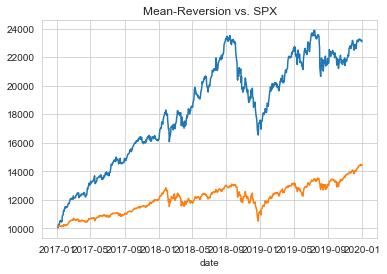

In [41]:
algo_return = pd.DataFrame(10000*np.cumprod(day_ret),index = s_ret_test.index,columns = ["mean_reversion"])
algo_return = algo_return.join((10000* np.cumprod(s_ret_test['SPX'])))
plt.plot(algo_return)
plt.xlabel('date')
plt.title('Mean-Reversion vs. SPX')
print("sharpe ratios: ")
print(algo_return.pct_change()[1:].mean() * np.sqrt(252)/algo_return.pct_change()[1:].std())

In [50]:
print(algo_return.pct_change()[1:].mean() * 252 * 100)

mean_reversion    29.615869
SPX               12.815448
dtype: float64


In [51]:
print(algo_return.pct_change()[1:].std() * np.sqrt(252) * 100)

mean_reversion    18.51327
SPX               12.80316
dtype: float64


In [ ]:
'''''
opt_s_tech = pd.DataFrame(columns=s_tech_train.columns, index=('sharpe_opt','sortino_opt'))
for column in s_tech_train:
    print('currently on: ' + str(column))
    s_score = pd.DataFrame(s_tech.AAPL).rename({column: str(column)+"_s"},axis=1)
    s_score = s_score.join(stetf[str(column)]+1)
    curr_sh,curr_so =opt_grid_params(s_score) 
    opt_s_tech[column]  = [list(curr_sh),list(curr_so)]
''''''

In [39]:
''''
from itertools import product
import random
def opt_grid_params(s_score):
    metrics = metrics = pd.DataFrame(columns=['cap','mean_ret','std','sharpe','sortino','buy_s','cut_s'])
    params = list(product(params_b,params_c))
    params = random.sample(params,60)
    for b in params: 
        dc,dr,ds,dso = sim_arbitrage(s_score,b[0],b[1],1)
        metrics = metrics.append({'cap':dc.value[-1],'mean_ret':dr.mean()[0],'std':dr.std()[0],'sharpe':ds[0],'sortino':dso[0],'buy_s':b[0],'cut_s':b[1]},ignore_index = True)
    metrics_sh = metrics[metrics.sharpe == metrics.sharpe.max()]
    metrics_so = metrics[metrics.sortino == metrics.sortino.max()]
    print(metrics_sh)
    print(metrics_so)
    sh = metrics_sh.iloc[0][['buy_s','cut_s']]
    so = metrics_so.iloc[0][['buy_s','cut_s']]
    return sh,so
    
def sim_arbitrage(s_score,buy_s,cut_s,cap=1): 
    daily_cap = []
    long = False
    for i in s_score.iterrows(): 
        curr_d = i[0]
        curr_s = i[1][0]
        curr_r = i[1][1]
        daily_cap.append(cap)
        if long == True: 
            cap = cap * curr_r
            if curr_s > cut_s: 
                long = False

        #elif short == True: 
        #    cap = cap * (((curr_r - 1) * -1) + 1)
        #    if curr_s <= -.5: 
        #        short = False

        if curr_s <= buy_s: 
            long = True
        #elif curr_s > 1.25: 
        #    short = True
        
    daily_cap = pd.DataFrame(daily_cap,index = s_score.index,columns= ['value'])
    daily_ret = daily_cap.pct_change()[1:]
    sharpe = daily_ret.mean()/daily_ret.std()
    sortino = daily_ret.mean()/daily_ret[daily_ret<0].std()
    #if(out == 'sh'): 
    return daily_cap,daily_ret,sharpe,sortino
    #if(out == 'so'): 
       # return sortino
